# depth losses analysis script

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

from oceantracker.post_processing.read_output_files import load_output_files 
from oceantracker.util.polygon_util import InsidePolygon
# from oceantracker.post_processing.plotting import plot_statistics
# from oceantracker.post_processing.plotting import stats_plot 


In [2]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v09'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)


In [17]:
# observational polygons in which to calculate concentrations
observational_polygone = [
    {
        'name': 'pre-splitting',
        'points': np.array([
           [572085,5922830],
           [572169,5922719],
           [572246,5922848],
           [572162,5922948] 
        ])
    },
    # norderelbe
    ## low-depth
    {
        'name': 'norder-bunthaus',
        'points': np.array([
            [570470,5925498],
            [570537,5925521],
            [570508,5925681],
            [570433,5925668]
        ])
    },
    {
        'name': 'norder-kaltehofe',
        'points': np.array([
            [569021,5931319],
            [569084,5931274],
            [569139,5931362],
            [569077,5931410]
        ])
    },
    ## medium-depth
    {
        'name': 'norder-elphi',
        'points': np.array([
            [565158,5932675],
            [565229,5932795],
            [565151,5932838],
            [565069,5932716]
        ])
    },
    ## high-depth
    {
        'name': 'norder-dockland',
        'points': np.array([
            [562387,5933002],
            [562390,5932860],
            [562513,5932872],
            [562507,5933012]
        ])
    },
    # suederelbe
    ## low-depth
    {
        'name': 'sueder-bunthaus',
        'points': np.array([
            [570405,5923818],
            [570454,5923894],
            [570397,5923946],
            [570345,5923871]
        ])
    },
    {
        'name': 'sueder-eurpabruecke',
        'points': np.array([
            [565993,5925470],
            [566099,5925433],
            [566083,5925340],
            [565977,5925374]
        ])
    },
    ## medium depth
    {
        'name': 'sueder-nynas',
        'points': np.array([
            [563601,5926690],
            [563675,5926768],
            [563630,5926837],
            [563552,5926761]
        ])
    },
    ## high depth
    {
        'name': 'sueder-kohlbrandt',
        'points': np.array([
            [562176,5931052],
            [562290,5931042],
            [562293,5931190],
            [562180,5931192]
        ])
    },
    # post sueder-norder unification
    {
        'name': 'post-unification',
        'points': np.array([
            [560484,5932946],
            [560485,5932765],
            [560640,5932764],
            [560637,5932946]
        ])
    }
]

In [5]:
# load grid
grid = load_output_files.load_grid(cases[0])

In [4]:
# load concentration field
concentration = load_output_files.load_concentration_vars(
            cases[0], var_list=['particle_concentration'])


###  Creating the polygon stats based on the tracks

In [28]:
# for each obs poly create a InsidePolygon object
# with this object we extract the triangles of the grid which are part of the polygon
# with the subsets of triangles we can calculate the concentration in the polygon (and reduce data size)

# create InsidePolygon objects
for poly in observational_polygone:
    poly['InsidePolygon'] = InsidePolygon(poly['points'])

# get triangles of grid which are part of the polygon

# get triangles of grid
triangles = grid['triangles']
# nodes of triangles
x = grid['x']

for poly in observational_polygone:
    print(poly['name'])
    poly['triangles'] = []

    for ii,tri in enumerate(triangles):
        if ii%10000 == 0: print(ii)
        nodes = x[tri]
        # check if triangle is part of polygon

        if poly['InsidePolygon'].is_inside(nodes).any():
            poly['triangles'].append(ii)

    poly['triangles'] = np.array(poly['triangles'])
    print(poly['triangles'])
        
    

    

pre-splitting
0
10000
20000
30000
40000
50000
60000
[7724 7725 7726 7746 7747 7748 7749 7750 7751 7752 7754 7768 7769 7770
 7771 7772 7773 7774 7777 7780 7797 7798 7799 7800]
norder-bunthaus
0
10000
20000
30000
40000
50000
60000
[9272 9273 9274 9275 9279 9280 9288 9319 9320 9321 9322 9323 9324 9325
 9326 9327 9336 9365 9366 9367 9368 9369]
norder-kaltehofe
0
10000
20000
30000
40000
50000
60000
[13149 13150 13151 13152 13153 13154 13156 13199 13200 13201 13202 13203
 13204 13205 13206 13249 13251 13252 13253 13254 13255 13256]
norder-elphi
0
10000
20000
30000
40000
50000
60000
[17171 17172 17173 17174 17176 17235 17237 17238 17239 17240 17242 17313
 17315 17316 17317 17318]
norder-dockland
0
10000
20000
30000
40000
50000
60000
[18310 18311 18312 18313 18314 18315 18317 18346 18347 18348 18349 18350
 18351 18352 18353 18383 18385 18386 18387 18388]
sueder-bunthaus
0
10000
20000
30000
40000
50000
60000
[]
sueder-eurpabruecke
0
10000
20000
30000
40000
50000
60000
[11211 11212 11213 11214 1

### post process polygon based data

In [24]:
for poly in observational_polygone:
    if len(poly['triangles']) > 0:
        poly['concentration'] = np.average(concentration['particle_concentration'][:,poly['triangles']],axis=1)
    else:
        poly['concentration'] = np.full(concentration['particle_concentration'].shape[0],np.nan)

# create a pandas df with concentration data
import pandas as pd

df = pd.DataFrame()
for poly in observational_polygone:
    df[poly['name']] = poly['concentration']
df['time'] = concentration['time']

# transform time from posix to datetime
df['time'] = pd.to_datetime(df['time'],unit='s')



KeyError: 'triangles'

### plot concentrations per poly

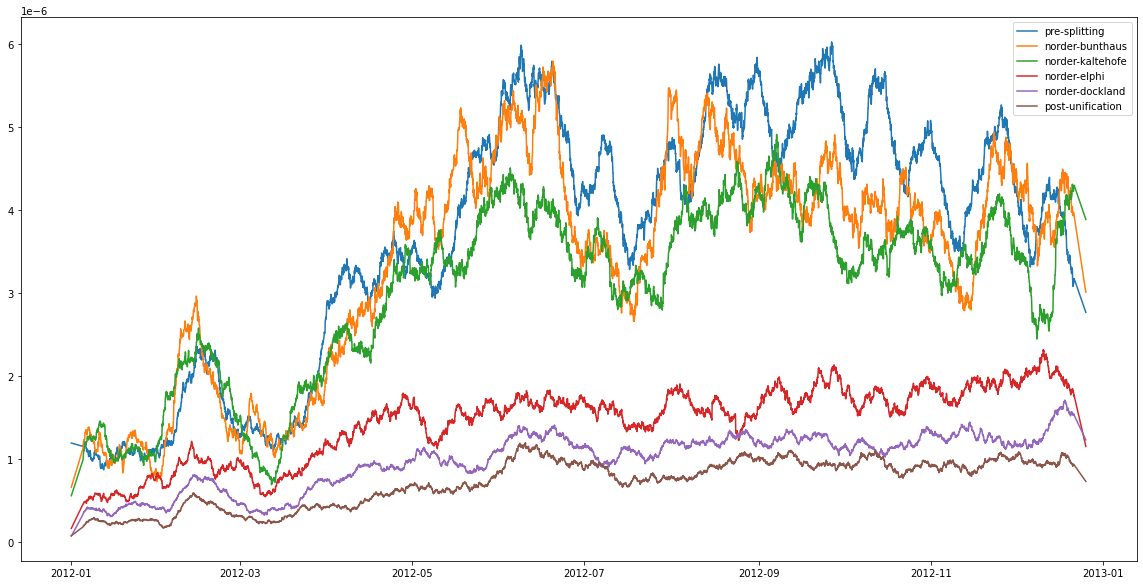

In [7]:
# same as above with a low pass filter (savitzky golay)
from scipy.signal import savgol_filter

filter_window = 201

plt.figure(figsize=(20,10))
plt.plot(df['time'],savgol_filter(df['pre-splitting'],filter_window,1),label='pre-splitting')

# plot all polies with norder in name
for keys in df.keys():
    if 'norder' in keys:
        plt.plot(df['time'],savgol_filter(df[keys],filter_window,1),label=keys)

plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1),label='post-unification')
plt.legend()


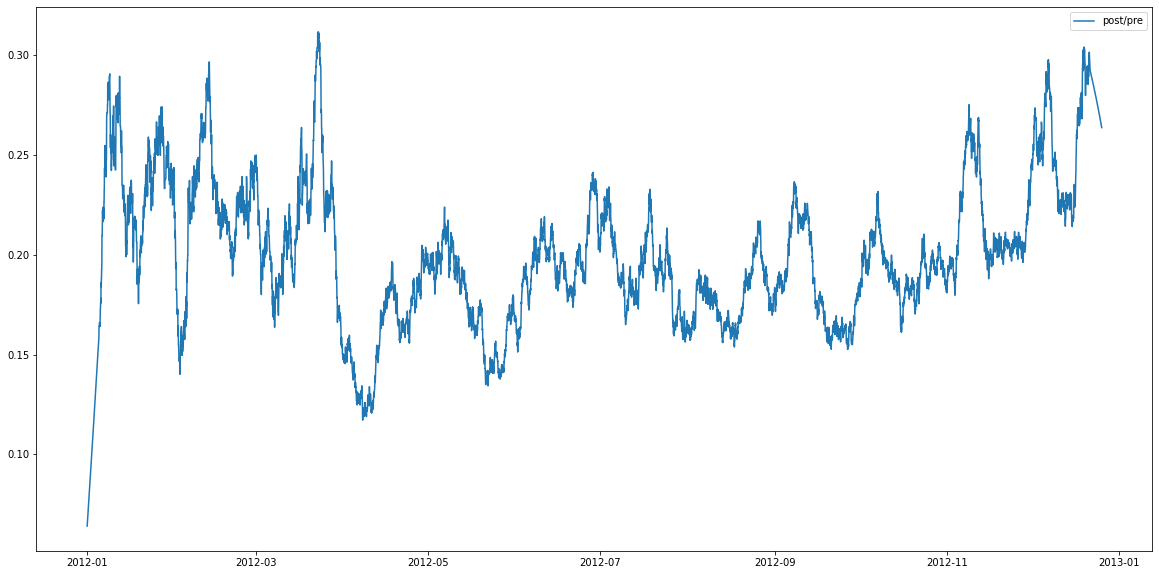

In [8]:
# plot post relative to pre
plt.figure(figsize=(20,10))

plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1)/savgol_filter(df['pre-splitting'],filter_window,1),label='post/pre')

plt.legend()


## Does the salinity cut off cause the loss of particles in between pre and post harbor?

In [10]:
### load salinity data

In [27]:
from netCDF4 import Dataset

# temp open file
data =  Dataset('/scratch/local1/hzg2/schout_11.nc')
salt = data.variables['salt'][:].filled(np.nan)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
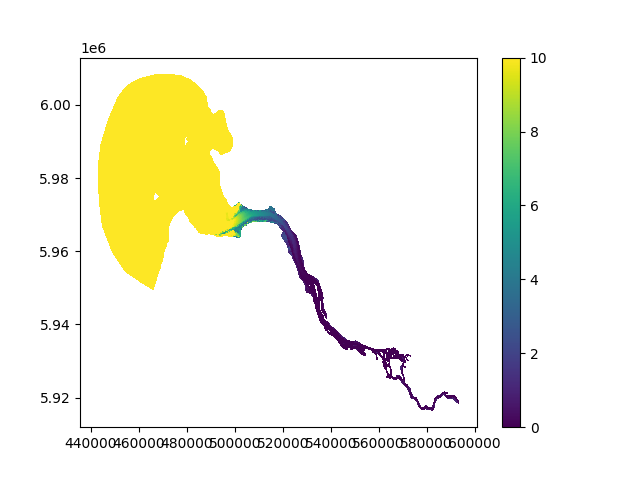

In [7]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.max(np.max(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,10)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
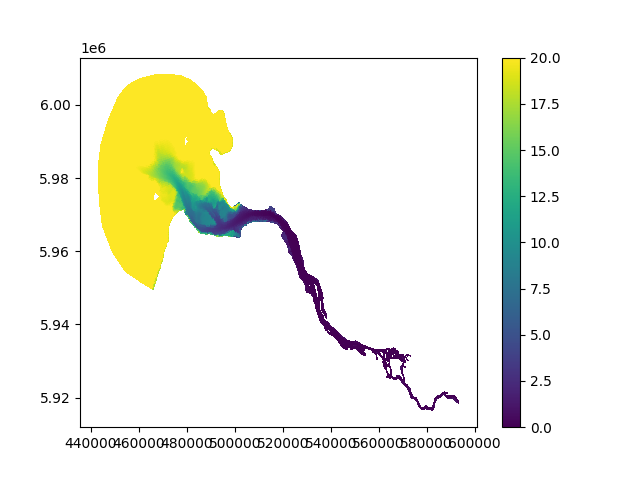

In [24]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.min(np.min(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,20)

plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
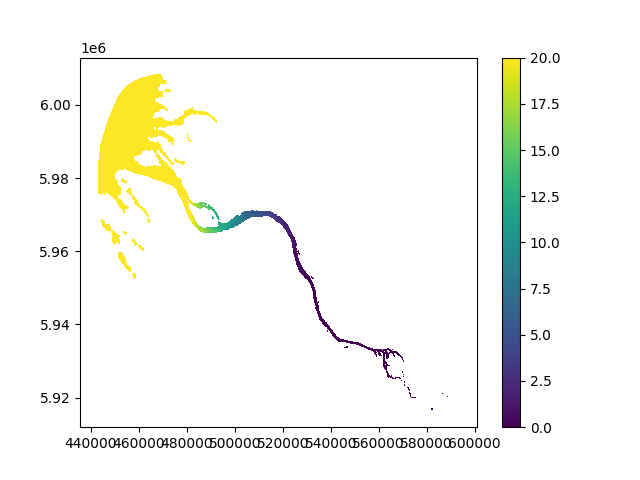

In [28]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.max(np.max(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,20)

plt.colorbar()

### comment

There are "high salinity" areas before the we enter the max turbidity zones. especially some shores with >1PSU values
Rerun the model with a 10PSU cut-off to make sure that this does not cause the issue (hopefully)

## Looking at vertical distribution

Are there i.e. aggregations on the top or bottom of the water column that might cause the loss in tracers

In [51]:
# tracks
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

In [29]:
observational_polygone[-1]['InsidePolygon'].is_inside(x)

array([False, False, False, ..., False, False, False])

In [30]:
sliced_tracks = tracks['x'][np.where(tracks['status'] > 0)]
sliced_tracks = sliced_tracks[:,:]

In [31]:
sliced_tracks = sliced_tracks[observational_polygone[-1]['InsidePolygon'].is_inside(sliced_tracks)]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
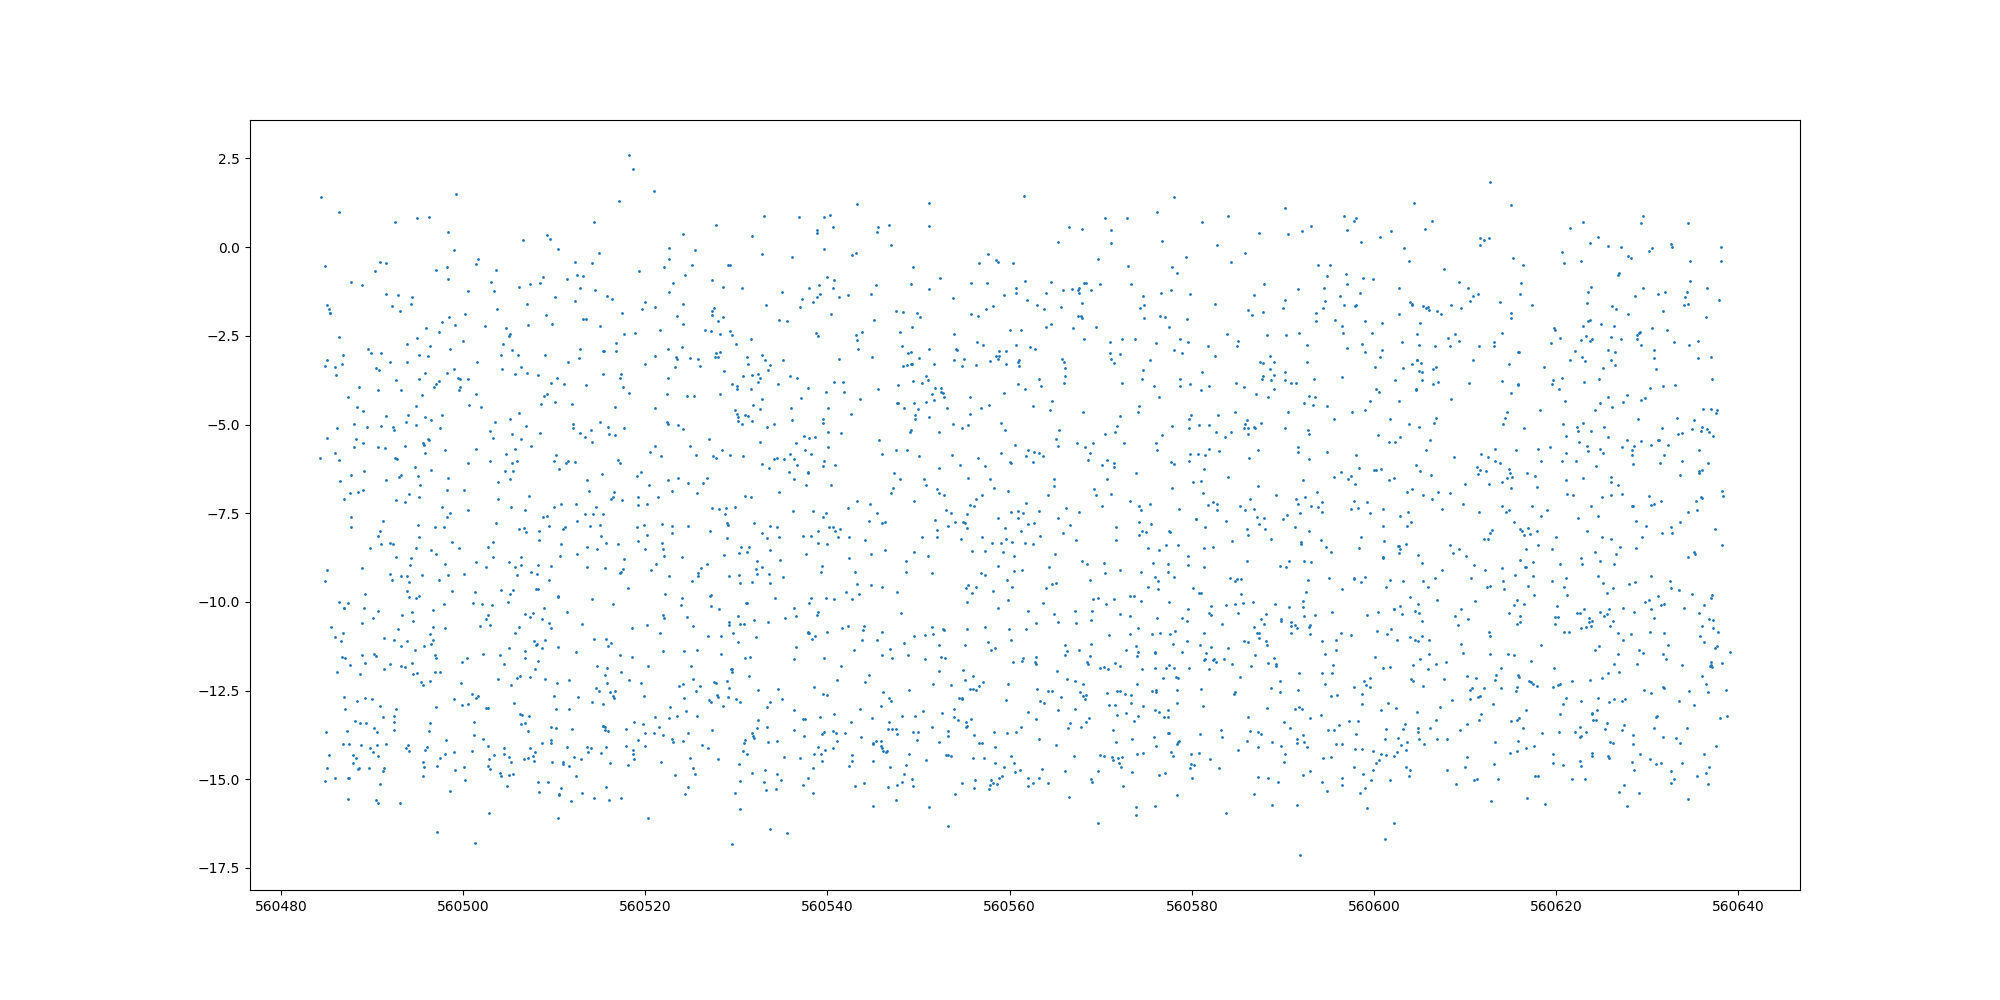

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(sliced_tracks[:,0],sliced_tracks[:,2],s=1)

In [21]:
from copy import deepcopy

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
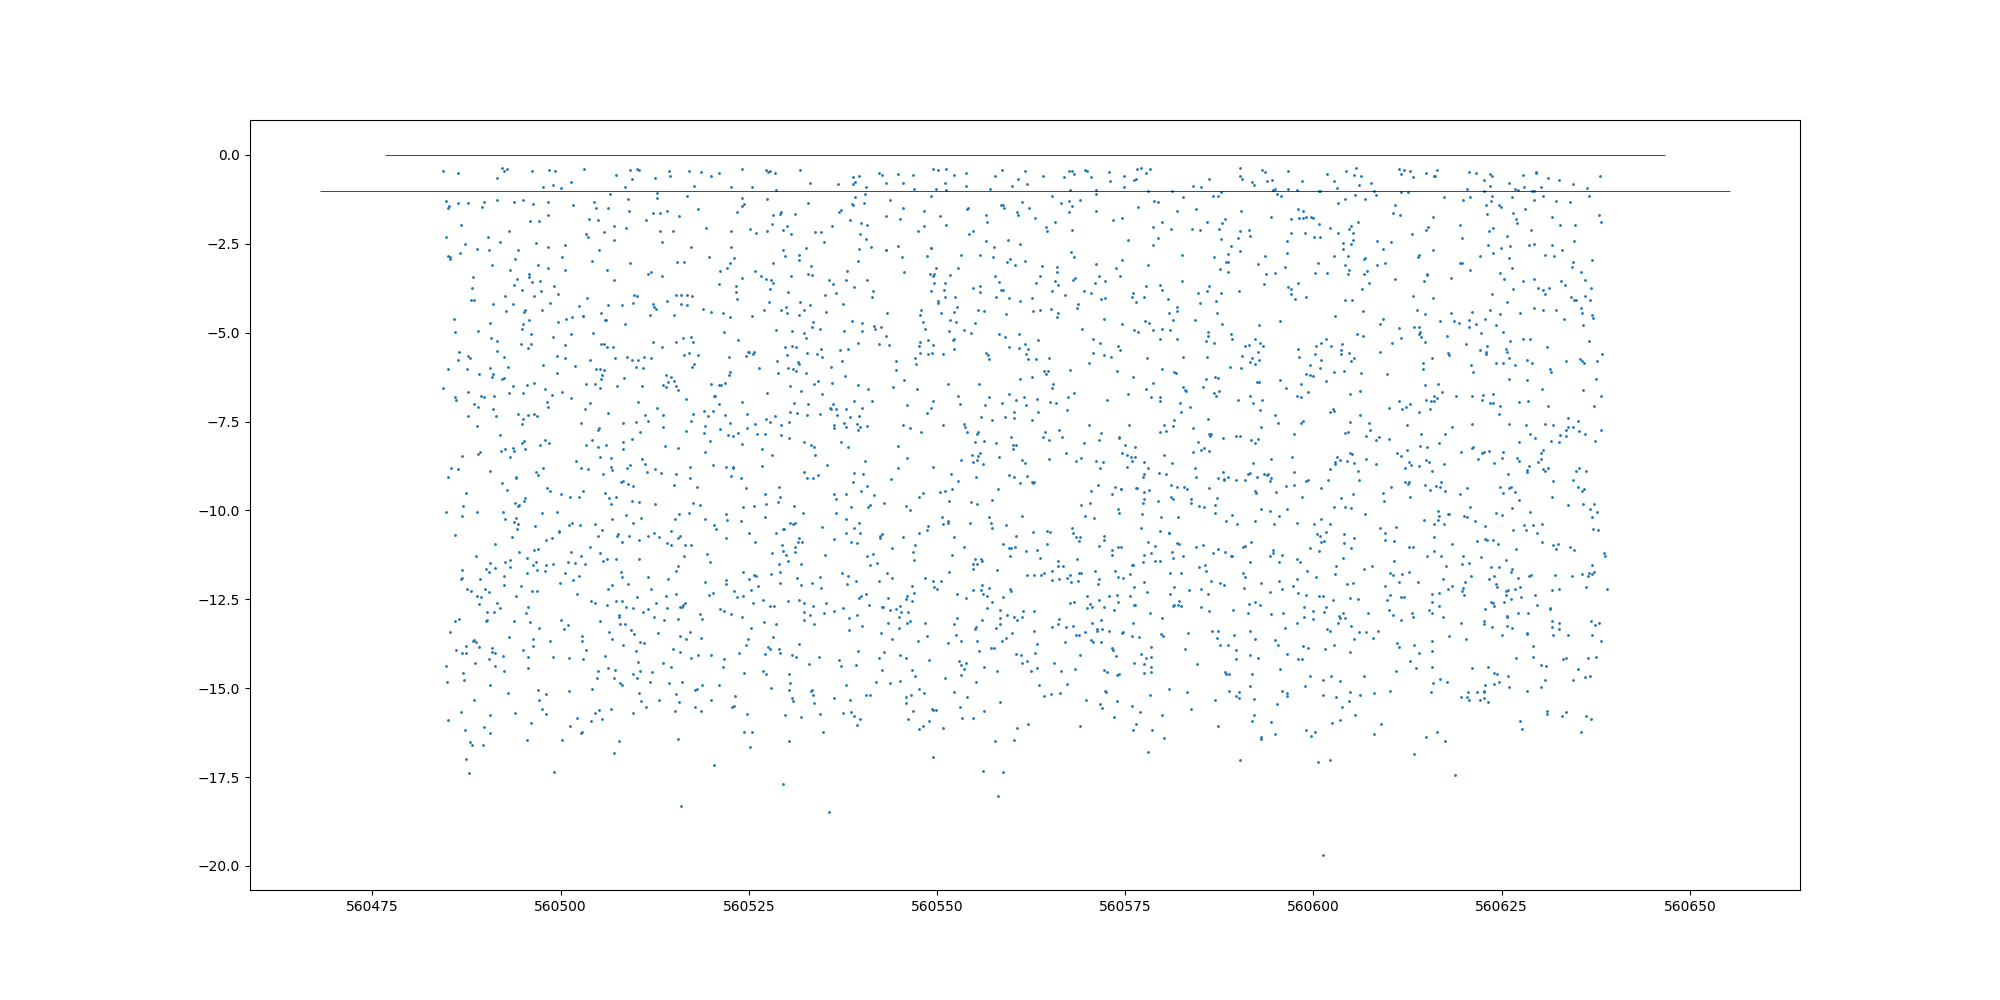

In [52]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[-1]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# calc distance from surface
distance_from_surface = z - surface

plt.figure(figsize=(20,10))
plt.scatter(x[:,0],distance_from_surface,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)

In [62]:
z[:10]

array([-13.60518071,  -1.62083153,  -8.73830067,  -0.43941736,
       -10.09565808,  -0.43196358, -10.0610919 ,  -4.98460356,
       -11.56844892,  -8.15794385])

(array([ 12., 280., 527., 431., 387., 504., 564., 124.,  17.,   3.]),
 array([-2.96468596, -2.25645252, -1.54821907, -0.83998562, -0.13175217,
         0.57648128,  1.28471472,  1.99294817,  2.70118162,  3.40941507,
         4.11764852]),
 <BarContainer object of 10 artists>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
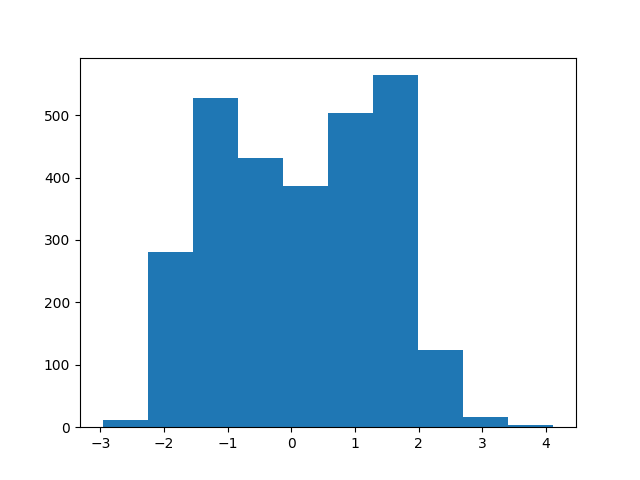

In [66]:
plt.figure()
plt.hist(surface[:])

(z - surface) / (-bottom - surface) = relative_depth
-1.62 - 1.5 / -16.69 - 1.5 = 0.17
-3.12 / -15.19 = 0.17


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
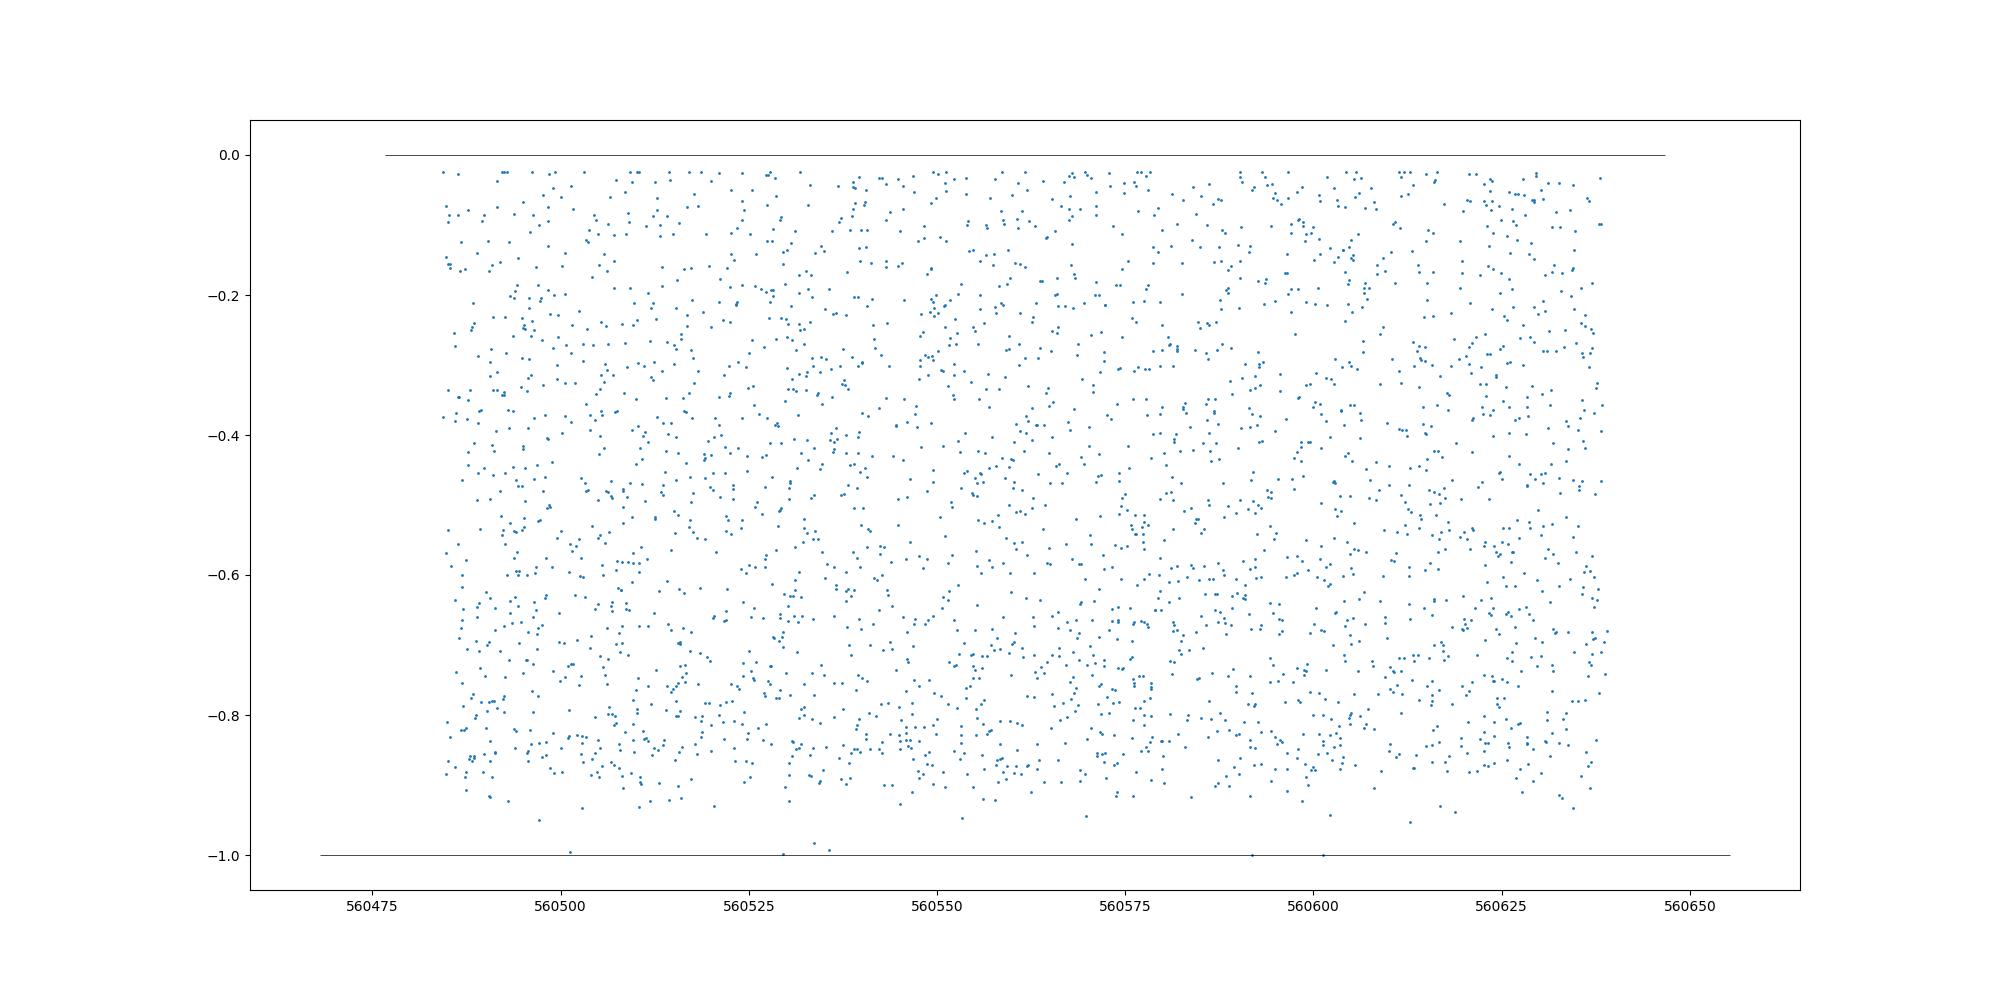

In [40]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[-1]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# scale vertical position linearly with 0 at surface and 1 at bottom
relative_depth = (z - surface)/(-bottom - surface)

# print an example of this equation with values for index ii
#(z - surface)/(-bottom - surface)

ii = 1
print('(z - surface) / (-bottom - surface) = relative_depth')
print(f'{round(z[ii],2)} - {round(surface[ii],2)} / -{round(bottom[ii],2)} - {round(surface[ii],2)} = {round(relative_depth[ii],2)}')
# simplify equation 
print(f'{round(z[ii] - surface[ii],2)} / -{round(bottom[ii] - surface[ii],2)} = {round(relative_depth[ii],2)}')


plt.figure(figsize=(20,10))
plt.scatter(x[:,0],-relative_depth,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)

In [46]:
-0.44-2.66

-3.1

In [45]:
ii = 3
print('(z - surface) / (-bottom - surface) = relative_depth')
print(f'{round(z[ii],2)} - {round(surface[ii],2)} / -{round(bottom[ii],2)} - {round(surface[ii],2)} = {round(relative_depth[ii],2)}')
# simplify equation 
print(f'{round(z[ii] - surface[ii],2)} / -{round(bottom[ii] - surface[ii],2)} = {round(relative_depth[ii],2)}')

(z - surface) / (-bottom - surface) = relative_depth
-0.44 - 2.66 / -17.39 - 2.66 = 0.15
-3.1 / -14.72 = 0.15


(z - surface) / (-bottom - surface) = relative_depth
-3.19 - 2.84 / -5.72 - 2.84 = 0.71
-6.04 / -2.87 = 0.71


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
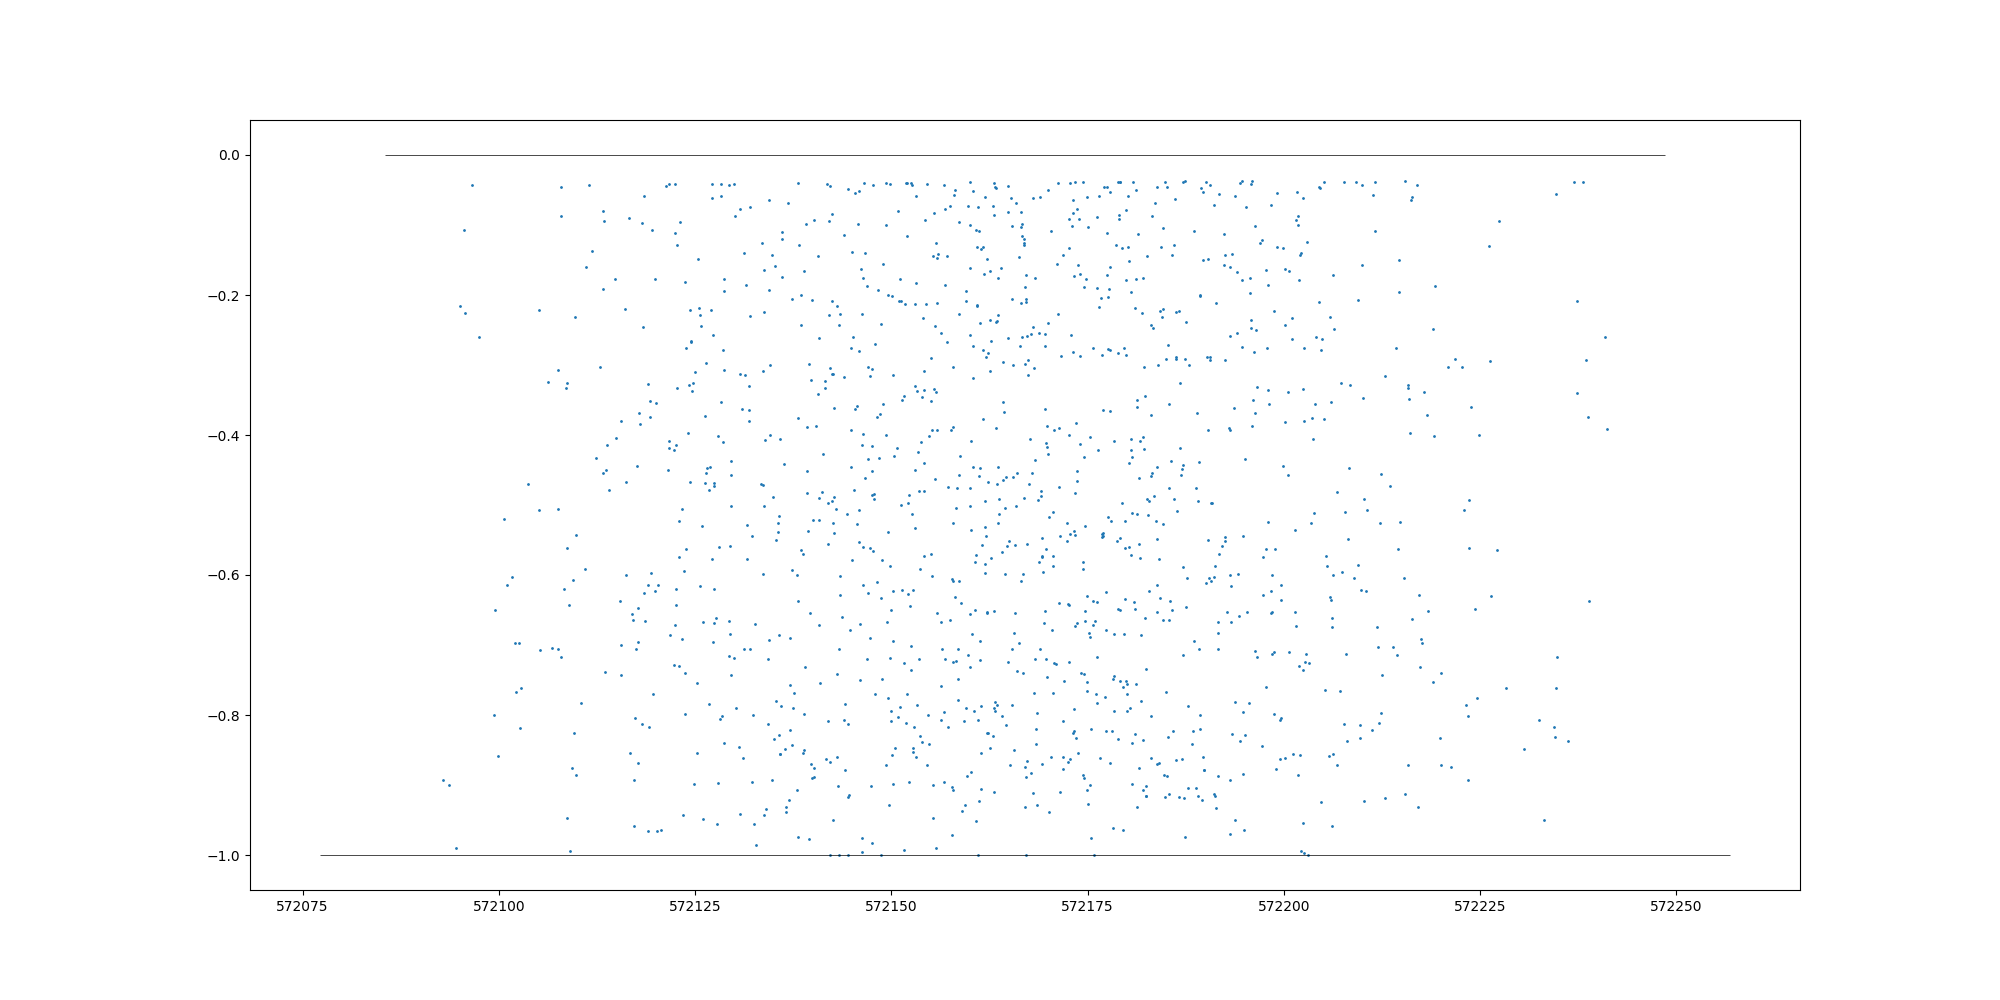

In [22]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[0]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# scale vertical position linearly with 0 at surface and 1 at bottom
relative_depth = (z - surface)/(-bottom - surface)

# print an example of this equation with values for index ii
#(z - surface)/(-bottom - surface)

ii = 1
print('(z - surface) / (-bottom - surface) = relative_depth')
print(f'{round(z[ii],2)} - {round(surface[ii],2)} / -{round(bottom[ii],2)} - {round(surface[ii],2)} = {round(relative_depth[ii],2)}')
# simplify equation 
print(f'{round(z[ii] - surface[ii],2)} / -{round(bottom[ii] - surface[ii],2)} = {round(relative_depth[ii],2)}')


plt.figure(figsize=(20,10))
plt.scatter(x[:,0],-relative_depth,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)

## where do they die?

In [3]:
# tracks
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

In [8]:
death = tracks['x'][:-1][np.array(np.array(np.diff(tracks['status'],axis=0) < 0)[:,:] * tracks['status'][1:,:] < 0)]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
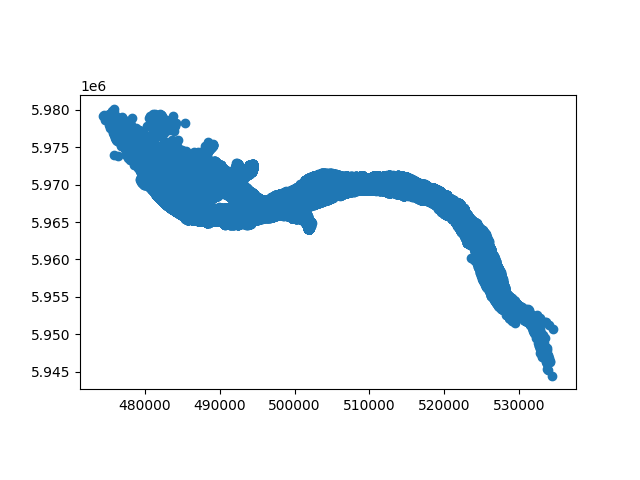

In [13]:
%matplotlib widget
fig,ax = plt.subplots(1,1)
plt.scatter(death[:,0], death[:,1])

# fix aspect ratio 
ax.set_aspect('equal', 'box')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
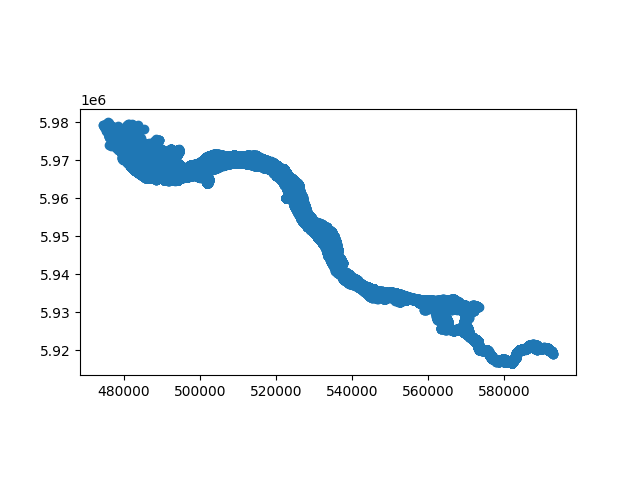

In [14]:
%matplotlib widget
fig,ax = plt.subplots(1,1)
plt.scatter(tracks['x'][-1,:,0], tracks['x'][-1,:,1])

# fix aspect ratio 
ax.set_aspect('equal', 'box')